In [1]:
from database.market import Market
from database.sec import SEC
import pandas as pd
import matplotlib.pyplot as plt
from processor.processor import Processor as p
from statistics import variance
from tqdm import tqdm
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta

In [2]:
market = Market()
sec = SEC()

In [3]:
# market.connect()
# prices = market.retrieve("alpha_prices")
# market.disconnect()

In [3]:
fed_fund = pd.read_csv("./csv_files/FEDFUNDS.csv")
spy = pd.read_csv("./csv_files/SPY.csv")
gdp = pd.read_csv("./csv_files/us_gdp.csv")
crude = pd.read_csv("./csv_files/cushing_crude.csv")
cpi = pd.read_csv("./csv_files/cpi.csv")
unemployment = pd.read_excel("./csv_files/unemployment.xlsx")

In [4]:
spy

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.968750,45.125000,42.812500,44.406250,25.820545,5417600
1,1993-03-01,44.562500,45.843750,44.218750,45.187500,26.274803,3019200
2,1993-04-01,45.250000,45.250000,43.281250,44.031250,25.723417,2697200
3,1993-05-01,44.093750,45.656250,43.843750,45.218750,26.417131,1808000
4,1993-06-01,45.375000,45.812500,44.218750,45.062500,26.325878,3438000
...,...,...,...,...,...,...,...
347,2022-01-01,476.299988,479.980011,420.760010,449.910004,448.516632,2485167800
348,2022-02-01,450.679993,458.119995,410.640015,436.630005,435.277771,2297975100
349,2022-03-01,435.040009,462.070007,415.119995,451.640015,450.241272,2380929500
350,2022-04-01,453.309998,457.829987,443.470001,447.570007,447.570007,487048500


In [5]:
unemployment = unemployment[11:].rename(columns={list(unemployment.columns)[i]:str(i) for i in range(1,13)})

In [6]:
ue = unemployment.rename(columns={"Labor Force Statistics from the Current Population Survey":"year"})

In [7]:
ue_final = pd.melt(ue,id_vars="year").dropna().sort_values("year").rename(columns={"variable":"month","value":"unemployment"})
ue_final["unemployment"] = [float(x) for x in ue_final["unemployment"]]

In [8]:
cpi_sorta = cpi[(cpi["FREQUENCY"]=="Q") & (cpi["Subject"]=='CPI: 01-12 - All items')][["TIME","Value"]].copy()
crude_sorta = crude.rename(columns={"04/4/2022":"date","103.29":"value"}).copy()

In [9]:
cpi_sorta["year"] = [int(x.split("-")[0]) for x in cpi_sorta["TIME"]]
cpi_sorta["quarter"] = [int(x.split("-")[1][1]) for x in cpi_sorta["TIME"]]

In [10]:
cpi_final = cpi_sorta.rename(columns={"Value":"cpi"})[["year","quarter","cpi"]]

In [11]:
crude_sorta["date"]= pd.to_datetime(crude_sorta["date"])

In [12]:
ue_final["year"] = [int(x) for x in ue_final["year"]]
ue_final["month"] = [int(x) for x in ue_final["month"]]

In [13]:
crude_final = crude_sorta.rename(columns={"value":"crude"})

In [14]:
gdp_final = gdp[gdp["Country Code"]=="USA"].melt(id_vars=["Country Code"]).iloc[3:].dropna().rename(columns={"variable":"year","value":"gdp"})

In [15]:
gdp_final["year"] = [int(x) for x in gdp_final["year"]]
gdp_final["gdp"] = [float(x) for x in gdp_final["gdp"]]

In [16]:
cpi_final

,year,quarter,cpi
388,2000,1,3.240178
389,2000,2,3.329322
390,2000,3,3.508073
391,2000,4,3.427100
392,2001,1,3.393488
...,...,...,...
6080,2020,4,0.229950
6081,2021,1,1.073114
6082,2021,2,2.339789
6083,2021,3,1.600975


In [17]:
fed_fund = p.column_date_processing(fed_fund)
fed_fund["fedfunds"] = [float(x) for x in fed_fund["fedfunds"]]
spy = p.column_date_processing(spy)

In [18]:
spy["year"] = [x.year for x in spy["date"]]
spy["quarter"] = [x.quarter for x in spy["date"]]
spy["month"] = [x.month for x in spy["date"]]

In [19]:
fed_fund["year"] = [x.year for x in fed_fund["date"]]
fed_fund["quarter"] = [x.quarter for x in fed_fund["date"]]
fed_fund = fed_fund.groupby(["year","quarter"]).mean().reset_index()

In [20]:
data = spy[["date","year","quarter","month","adjclose"]].merge(fed_fund[["year","quarter","fedfunds"]],on=["year","quarter"],how="left") \
        .merge(gdp_final[["year","gdp"]],on="year",how="left") \
        .merge(crude_final,on="date",how="left") \
        .merge(cpi_final,on=["year","quarter"],how="left") \
        .merge(ue_final,on=["year","month"],how="left").dropna().groupby(["date"]).mean().reset_index()

In [21]:
market.connect()
market.store("econ",data)
market.disconnect()

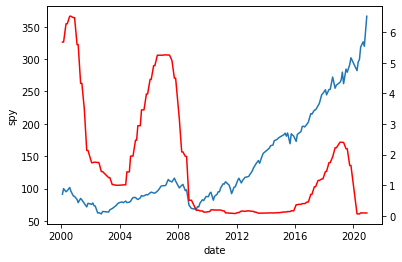

In [22]:
secondary = "fedfunds"
fig,ax = plt.subplots()
ax.plot(data["date"],data["adjclose"])
ax.set_xlabel("date")
ax.set_ylabel("spy")
ax2 = ax.twinx()
ax2.plot(data["date"],data[secondary],color="red")
ax2.set_xlabel("fedfunds")
plt.show()

In [23]:
dataset = []
for year in tqdm(range(2000,2023)):
    for quarter in range(1,5):
        try:
            year_training_data = spy[(spy["year"]==year) & (spy["quarter"]==quarter)]
            print(year_training_data.index.size,year,quarter)
            year_label = spy[(spy["year"]==year+3) & (spy["quarter"]==quarter)]
            var = variance(year_training_data["adjclose"])
            delta = (year_training_data.tail(1)["adjclose"].item() - year_training_data.iloc[0]["adjclose"]) / year_training_data.iloc[0]["adjclose"]
            average_spy = year_training_data["adjclose"].mean()
            average_spy_label = year_label["adjclose"].mean()
            delta_label = (year_label.tail(1)["adjclose"].item() - year_label.iloc[0]["adjclose"]) / year_label.iloc[0]["adjclose"]
            dataset.append({
                "year":year,
                "quarter":quarter,
                "variance":var,
                "delta":delta,
                "spy":average_spy,
                "spy_label":average_spy_label,
                "delta_label":delta_label
            })
        except Exception as e:
            print(year,quarter,str(e))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 155.37it/s]

3 2000 1
3 2000 2
3 2000 3
3 2000 4
3 2001 1
3 2001 2
3 2001 3
3 2001 4
3 2002 1
3 2002 2
3 2002 3
3 2002 4
3 2003 1
3 2003 2
3 2003 3
3 2003 4
3 2004 1
3 2004 2
3 2004 3
3 2004 4
3 2005 1
3 2005 2
3 2005 3
3 2005 4
3 2006 1
3 2006 2
3 2006 3
3 2006 4
3 2007 1
3 2007 2
3 2007 3
3 2007 4
3 2008 1
3 2008 2
3 2008 3
3 2008 4
3 2009 1
3 2009 2
3 2009 3
3 2009 4
3 2010 1
3 2010 2
3 2010 3
3 2010 4
3 2011 1
3 2011 2
3 2011 3
3 2011 4
3 2012 1
3 2012 2
3 2012 3
3 2012 4
3 2013 1
3 2013 2
3 2013 3
3 2013 4
3 2014 1
3 2014 2
3 2014 3
3 2014 4
3 2015 1
3 2015 2
3 2015 3
3 2015 4
3 2016 1
3 2016 2
3 2016 3
3 2016 4
3 2017 1
3 2017 2
3 2017 3
3 2017 4
3 2018 1
3 2018 2
3 2018 3
3 2018 4
3 2019 1
3 2019 2
3 2019 3
2019 3 can only convert an array of size 1 to a Python scalar
3 2019 4
2019 4 can only convert an array of size 1 to a Python scalar
3 2020 1
2020 1 can only convert an array of size 1 to a Python scalar
3 2020 2
2020 2 can only convert an array of size 1 to a Python scalar
3 2020 3
2020 

In [24]:
practice_set = pd.DataFrame(dataset)

In [25]:
practice_set["classification_label"] = [x > 0 for x in practice_set["delta_label"]]

In [26]:
practice_set

,year,quarter,variance,delta,spy,spy_label,delta_label,classification_label
0,2000,1,21.215191,0.077474,94.577227,58.830393,-0.015338,False
1,2000,2,0.836804,0.001292,96.107147,66.180209,0.062235,True
2,2000,3,12.144374,0.004370,97.619110,69.732229,0.005635,True
3,2000,4,18.900713,-0.082304,90.608302,75.178129,0.056790,True
4,2001,1,47.771006,-0.148372,84.454338,79.875511,-0.003349,False
...,...,...,...,...,...,...,...,...
73,2018,2,12.688173,0.025595,251.125351,416.321401,0.025785,True
74,2018,3,24.782711,0.033377,269.647726,435.445078,-0.021368,False
75,2018,4,165.176256,-0.076525,250.087433,460.205149,0.034208,True
76,2019,1,37.206401,0.046493,262.570842,444.678558,0.003845,True


In [27]:
econ_set = data.merge(practice_set[["year","quarter","variance","delta","spy","spy_label","classification_label"]],on=["year","quarter"],how="left")

In [28]:
econ_set = econ_set.groupby(["year","quarter"]).mean().reset_index().dropna()

In [29]:
econ_set

,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment,variance,delta,spy,spy_label
0,2000.0,1.0,2.5,95.538479,5.676667,1.025235e+13,29.995,63.525534,4.05,21.215191,0.077474,94.577227,58.830393
1,2000.0,2.0,5.5,95.874889,6.273333,1.025235e+13,28.015,64.181506,4.00,0.836804,0.001292,96.107147,66.180209
2,2000.0,3.0,8.5,98.727536,6.520000,1.025235e+13,30.635,64.685434,4.00,12.144374,0.004370,97.619110,69.732229
3,2000.0,4.0,11.5,88.107174,6.473333,1.025235e+13,32.600,64.987401,3.90,18.900713,-0.082304,90.608302,75.178129
4,2001.0,1.0,2.5,80.719791,5.593333,1.058182e+13,28.830,65.678992,4.25,47.771006,-0.148372,84.454338,79.875511
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2018.0,2.0,5.5,253.179856,1.736667,2.061186e+13,66.545,93.388353,3.90,12.688173,0.025595,251.125351,416.321401
70,2018.0,3.0,8.0,272.327515,1.923333,2.061186e+13,68.800,93.558882,3.80,24.782711,0.033377,269.647726,435.445078
71,2018.0,4.0,10.5,257.380860,2.220000,2.061186e+13,69.520,93.430727,3.80,165.176256,-0.076525,250.087433,460.205149
72,2019.0,1.0,2.5,265.935532,2.403333,2.143322e+13,55.525,93.688690,3.80,37.206401,0.046493,262.570842,444.678558


In [30]:
training_set = econ_set[practice_set["year"]<2019]
prediction_set = econ_set[practice_set["year"]>=2019]
prediction_set["date"] = [datetime(int(row[1]["year"]),int(3*(row[1]["quarter"] - 1)+1),1) for row in prediction_set.iterrows()]
econ_set["date"] = [datetime(int(row[1]["year"]),int(3*(row[1]["quarter"] - 1)+1),1) for row in econ_set.iterrows()]

In [31]:
training_set

,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment,variance,delta,spy,spy_label
0,2000.0,1.0,2.5,95.538479,5.676667,1.025235e+13,29.995,63.525534,4.05,21.215191,0.077474,94.577227,58.830393
1,2000.0,2.0,5.5,95.874889,6.273333,1.025235e+13,28.015,64.181506,4.00,0.836804,0.001292,96.107147,66.180209
2,2000.0,3.0,8.5,98.727536,6.520000,1.025235e+13,30.635,64.685434,4.00,12.144374,0.004370,97.619110,69.732229
3,2000.0,4.0,11.5,88.107174,6.473333,1.025235e+13,32.600,64.987401,3.90,18.900713,-0.082304,90.608302,75.178129
4,2001.0,1.0,2.5,80.719791,5.593333,1.058182e+13,28.830,65.678992,4.25,47.771006,-0.148372,84.454338,79.875511
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2018.0,2.0,5.5,253.179856,1.736667,2.061186e+13,66.545,93.388353,3.90,12.688173,0.025595,251.125351,416.321401
70,2018.0,3.0,8.0,272.327515,1.923333,2.061186e+13,68.800,93.558882,3.80,24.782711,0.033377,269.647726,435.445078
71,2018.0,4.0,10.5,257.380860,2.220000,2.061186e+13,69.520,93.430727,3.80,165.176256,-0.076525,250.087433,460.205149
72,2019.0,1.0,2.5,265.935532,2.403333,2.143322e+13,55.525,93.688690,3.80,37.206401,0.046493,262.570842,444.678558


In [32]:
factors = ["variance","fedfunds","delta","spy","gdp","crude","cpi","unemployment"]

In [33]:
# delta_model = m.regression({"X":training_set[factors],"y":training_set.rename(columns={"delta_label":"y"})[["y"]]})

In [34]:
spy_model = m.regression({"X":training_set[factors],"y":training_set.rename(columns={"spy_label":"y"})[["y"]]})

In [35]:
#classification_model = m.classification({"X":training_set[factors],"y":training_set.rename(columns={"classification_label":"y_class"})[["y_class"]]},xgb=True,sk=True,multioutput=False)

In [36]:
# classification_model = pd.DataFrame(classification_model)

In [37]:
# class_sim = prediction_set.copy()
# for row in classification_model.iterrows():
#     model = row[1]["model"]
#     api = row[1]["api"]
#     score = row[1]["score"]
#     predictions = model.predict(class_sim[factors])
#     class_sim[f"{api}_prediction"] = predictions
#     class_sim[f"{api}_score"] = score

In [38]:
# classification_model

In [39]:
spy_model

,api,model,score,model_type
0,skl,LinearRegression(),0.961793,regression
1,xgb,"XGBRegressor(base_score=0.5, booster='gblinear...",0.953349,regression
2,light,"LGBMRegressor(boosting_type='dart', early_stop...",0.504345,regression
3,cat,<catboost.core.CatBoostRegressor object at 0x0...,0.975541,regression


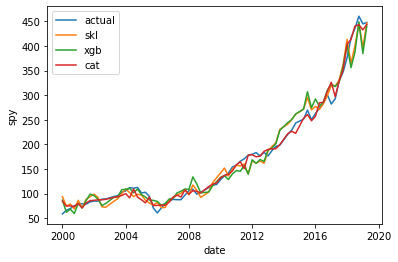

In [40]:
sim = econ_set.copy()
secondary = "cpi"
for row in spy_model.iterrows():
    model = row[1]["model"]
    api = row[1]["api"]
    score = row[1]["score"]
    predictions = model.predict(sim[factors])
    sim[f"{api}_prediction"] = predictions
    sim[f"{api}_score"] = score
fig,ax = plt.subplots()
ax.plot(sim["date"],sim["spy_label"])
for api in ["skl","xgb","cat"]:
    ax.plot(sim["date"],sim[f"{api}_prediction"])
ax.legend(["actual","skl","xgb","cat"])
ax.set_xlabel("date")
ax.set_ylabel("spy")
# ax2 = ax.twinx()
# ax2.plot(sim["date"],sim[secondary],color="purple")
# ax2.set_xlabel(secondary)
plt.show()

In [41]:
data

,date,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment
0,2000-02-01,2000.0,1.0,2.0,91.243927,5.676667,1.025235e+13,28.28,63.525534,4.1
1,2000-03-01,2000.0,1.0,3.0,99.833031,5.676667,1.025235e+13,31.71,63.525534,4.0
2,2000-05-01,2000.0,2.0,5.0,95.053322,6.273333,1.025235e+13,25.84,64.181506,4.0
3,2000-06-01,2000.0,2.0,6.0,96.696457,6.273333,1.025235e+13,30.19,64.181506,4.0
4,2000-08-01,2000.0,3.0,8.0,101.635895,6.520000,1.025235e+13,27.85,64.685434,4.1
...,...,...,...,...,...,...,...,...,...,...
155,2020-06-01,2020.0,2.0,6.0,299.551025,0.060000,2.095303e+13,35.49,94.648372,11.0
156,2020-07-01,2020.0,3.0,7.0,318.588104,0.093333,2.095303e+13,39.88,96.235574,10.2
157,2020-09-01,2020.0,3.0,9.0,326.754822,0.093333,2.095303e+13,42.76,96.235574,7.9
158,2020-10-01,2020.0,4.0,10.0,319.883026,0.090000,2.095303e+13,38.51,96.350188,6.9


In [42]:
dataset = []
for year in tqdm(range(2000,2023)):
    for quarter in range(1,5):
        try:
            year_training_data = spy[(spy["year"]==year) & (spy["quarter"]==quarter)]
            var = variance(year_training_data["adjclose"])
            delta = (year_training_data.tail(1)["adjclose"].item() - year_training_data.iloc[0]["adjclose"]) / year_training_data.iloc[0]["adjclose"]
            average_spy = year_training_data["adjclose"].mean()
            dataset.append({
                "year":year,
                "quarter":quarter,
                "variance":var,
                "delta":delta,
                "spy":average_spy,
            })
        except Exception as e:
            print(year,quarter,str(e))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 328.49it/s]

2022 3 variance requires at least two data points
2022 4 variance requires at least two data points


In [43]:
forward_set = pd.DataFrame(dataset)
forward_data = data.merge(forward_set,on=["year","quarter"]).groupby(["year","quarter"]).mean().reset_index()

In [44]:
spy_model

,api,model,score,model_type
0,skl,LinearRegression(),0.961793,regression
1,xgb,"XGBRegressor(base_score=0.5, booster='gblinear...",0.953349,regression
2,light,"LGBMRegressor(boosting_type='dart', early_stop...",0.504345,regression
3,cat,<catboost.core.CatBoostRegressor object at 0x0...,0.975541,regression


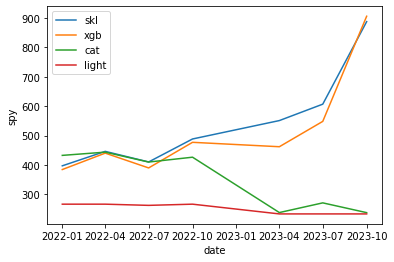

In [55]:
sim = forward_data[forward_data["year"]>2018].copy()
sim["date"] = [datetime(int(row[1]["year"]) +3,int(3*(row[1]["quarter"] - 1)+1),1) for row in sim.iterrows()]
secondary = "cpi"
for row in spy_model.iterrows():
    model = row[1]["model"]
    api = row[1]["api"]
    score = row[1]["score"]
    predictions = model.predict(sim[factors])
    sim[f"{api}_prediction"] = predictions
    sim[f"{api}_score"] = score
fig,ax = plt.subplots()
for api in ["skl","xgb","cat","light"]:
    ax.plot(sim["date"],sim[f"{api}_prediction"])
ax.legend(["skl","xgb","cat","light"])
ax.set_xlabel("date")
ax.set_ylabel("spy")
# ax2 = ax.twinx()
# ax2.plot(sim["date"],sim[secondary],color="purple")
# ax2.set_xlabel(secondary)
plt.show()

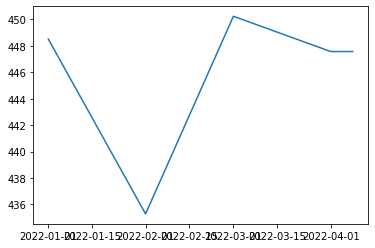

In [50]:
spy_viz = spy[spy["date"]>datetime(2021,12,1)]
plt.plot(spy_viz["date"],spy_viz["adjclose"])

In [51]:
spy_viz

,date,open,high,low,close,adjclose,volume,year,quarter,month
347,2022-01-01,476.299988,479.980011,420.760010,449.910004,448.516632,2485167800,2022,1,1
348,2022-02-01,450.679993,458.119995,410.640015,436.630005,435.277771,2297975100,2022,1,2
349,2022-03-01,435.040009,462.070007,415.119995,451.640015,450.241272,2380929500,2022,1,3
350,2022-04-01,453.309998,457.829987,443.470001,447.570007,447.570007,487048500,2022,2,4
351,2022-04-08,447.970001,450.630005,445.950012,447.570007,447.570007,79272711,2022,2,4


In [53]:
sim[sim["date"]>datetime(2021,12,1)][["date","skl_prediction","xgb_prediction","cat_prediction","light_prediction"]]

,date,skl_prediction,xgb_prediction,cat_prediction,light_prediction
72,2022-01-01,397.134420,384.476440,432.620265,266.822432
73,2022-04-01,446.253887,440.277588,443.593357,266.822432
74,2022-07-01,410.244302,389.943451,409.961529,262.759110
75,2022-10-01,488.365419,476.999146,426.436256,266.822432
76,2023-04-01,550.908022,462.002899,238.315346,233.707596
77,2023-07-01,606.681925,548.157104,271.254986,233.707596
78,2023-10-01,887.054887,905.415833,238.026224,233.707596


In [56]:
# import pickle 
# market.connect()
# spy_model["model"] = [pickle.dumps(x) for x in spy_model["model"]]
# market.store("econ_models",spy_model)
# market.disconnect()